In [30]:
# geopython env + mxnet1.6.0 env
import numpy as np
import pandas as pd
import imageio
import os
from scipy.stats import linregress
from scipy.stats.stats import pearsonr
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
import higra as hg
import scipy.ndimage as si
from skimage import measure
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
%matplotlib inline

# Instance segmentation post-processing

## Helper functions

In [2]:
def InstSegm(extent, boundary, t_ext=0.4, t_bound=0.2):
    """
    INPUTS:
    extent : extent prediction
    boundary : boundary prediction
    t_ext : threshold for extent
    t_bound : threshold for boundary
    OUTPUT:
    instances
    """

    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)

    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    input_hws[ext_binary == 0] = 1

    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean
    )

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights
    )
    
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound)
    
    instances[ext_binary == 0] = -1

    return instances

# Instance metrics

In [3]:
splits_path = '../data/splits/india_planetImagery_splits_20x20_v2.csv'
splits_df = pd.read_csv(splits_path, dtype=str)
splits_df['image_id'] = splits_df['image_id'].str.zfill(4)

In [4]:
train_ids = splits_df[splits_df['fold'] == 'train']['image_id'].values
val_ids = splits_df[splits_df['fold'] == 'val']['image_id'].values
test_ids = splits_df[splits_df['fold'] == 'test']['image_id'].values

## IoU

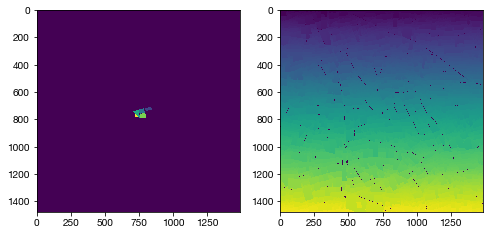

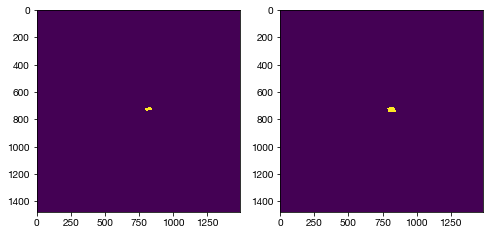

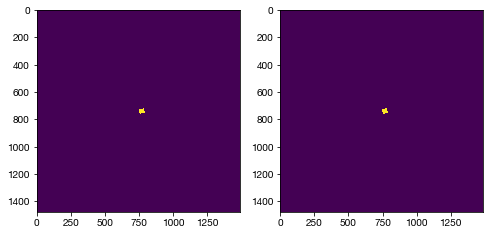

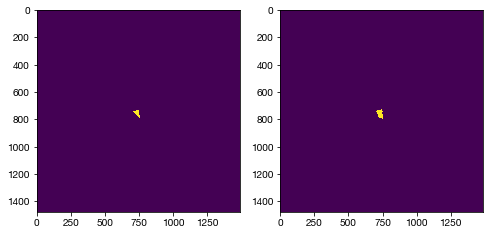

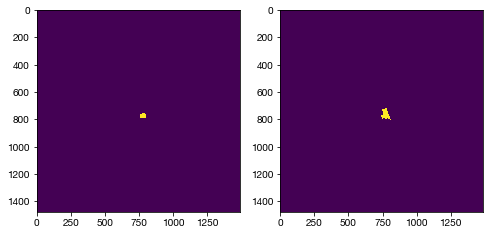

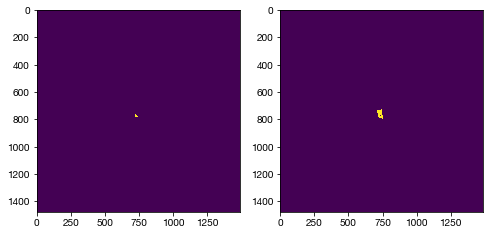

([0.7874439461883408,
  0.8308351177730193,
  0.6878205128205128,
  0.8144163528778914,
  0.6127049180327869],
 [955, 1244, 1423, 1525, 309])

In [8]:
i = 1987
image_id = str(i).zfill(4)
extent_true = imageio.imread('../data/general_blockchain/airbus_labels/large/original/airbus_geowiki_C{}.png'.format(image_id))
extent_pred = imageio.imread('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_1x-3x-downsampled-erosion2px_finetuned/Airbus_original/extent_full/airbus_geowiki_C{}.png'.format(image_id))
boundary_pred = imageio.imread('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_1x-3x-downsampled-erosion2px_finetuned/Airbus_original/boundary_full/airbus_geowiki_C{}.png'.format(image_id))
get_IoUs(extent_true, extent_pred, boundary_pred, plot=True)

In [8]:
def get_IoUs(extent_true, extent_pred, boundary_pred, t_ext=0.4, 
             t_bound=0.2, plot=False):
    
    # get predicted instance segmentation
    instances_pred = InstSegm(extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
    instances_pred = measure.label(instances_pred, background=-1)
    
    # get instances from ground truth label
    binary_true = extent_true > 0
    instances_true = measure.label(binary_true, background=0, connectivity=1)
    
    # remove non-cropland
    # kernel = np.ones((2,2), np.uint8)
    # cropland_mask = si.binary_closing(binary_true, structure=kernel, 
    #                                   iterations=4, border_value=1)
    # instances_pred = instances_pred * cropland_mask
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(instances_true)
        ax[1].imshow(instances_pred)
        plt.show()
    
    # loop through true fields
    field_values = np.unique(instances_true)
    best_IoUs = []
    field_sizes = []
    
    for field_value in field_values:
        if field_value == 0:
            continue # move on to next value
            
        this_field = instances_true == field_value
        field_sizes.append(np.sum(this_field))
        
        # find predicted fields that intersect with true field
        intersecting_fields = this_field * instances_pred
        intersect_values = np.unique(intersecting_fields)
        
        intersect_fields = np.isin(instances_pred, intersect_values[1:])
        
        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))
            ax[0].imshow(this_field)
            ax[1].imshow(intersect_fields)
            plt.show()
        
        # compute IoU for each intersecting field
        field_IoUs = []
        for intersect_value in intersect_values:
            if intersect_value == 0:
                continue # move on to next value
            pred_field = instances_pred == intersect_value
            union = this_field + pred_field > 0
            intersection = (this_field * pred_field) > 0
            IoU = np.sum(intersection) / np.sum(union)
            field_IoUs.append(IoU)
    
        # take maximum IoU - this is the IoU for this true field
        if len(field_IoUs) > 0:
            best_IoUs.append(np.max(field_IoUs))
        else:
            best_IoUs.append(0)
    
    return best_IoUs, field_sizes

## Airbus

### Visualize

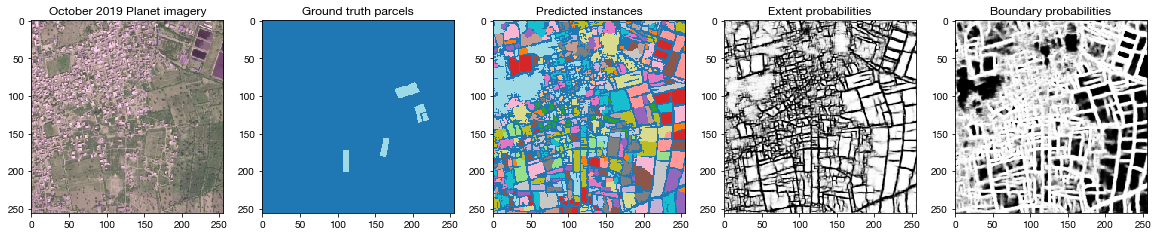

In [25]:
image_id = 'airbus_geowiki_C0000'
month = '2020_10'

img_dir = '../data/general_blockchain/airbus_false_color/large/3x_downsample_test/'
label_dir = '../data/general_blockchain/airbus_labels/large/3x_downsample_erosion2px_test/'
example_img = imageio.imread(os.path.join(img_dir, '{}.png'.format(image_id)))
example_truth = imageio.imread(os.path.join(label_dir, '{}.png'.format(image_id)))

model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_finetuned'
results_dir = '../results/india/GeneralBlockchain/{}/Airbus_3x_downsampled/'.format(model_name)
example_extent = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
example_boundary = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))

instances = InstSegm(example_extent, example_boundary)

# map instances to better range for plotting
unique_instances = sorted(np.unique(instances))
min_instance = unique_instances[1]
max_instance = unique_instances[-1]
n_instances = len(unique_instances)
instance_map = {x: i for i, x in enumerate(unique_instances)}
def map_values(x):
    return instance_map[x]
instances_mapped = np.array(list(map(map_values, instances.flatten()))).reshape( 
    instances.shape[0], instances.shape[1])


fig, ax = plt.subplots(1, 5, figsize=(20,4))
ax[0].imshow(example_img[:256,:256])
ax[0].set_title('October 2019 Planet imagery')
ax[1].imshow(example_truth[:256,:256], vmin=0, vmax=np.max(example_truth), cmap='tab20')
ax[1].set_title('Ground truth parcels')
ax[2].imshow(instances_mapped, vmin=0, vmax=n_instances+1, cmap='tab20')
ax[2].set_title('Predicted instances')
ax[3].imshow(example_extent, cmap='Greys_r', vmin=0, vmax=1)
ax[3].set_title('Extent probabilities')
ax[4].imshow(example_boundary, cmap='Greys_r', vmin=0, vmax=1)
ax[4].set_title('Boundary probabilities')

plt.show()

### Hyperparameter tuning

In [35]:
# hyperparameter values
t_exts = np.linspace(0.1, 0.5, 5)
t_bounds = np.linspace(0.0, 0.2, 3)
# t_exts = [0.4]
# t_bounds = [0.1]

# run for all test fields
image_ids = np.random.choice(val_ids, 50, replace=False)

# Airbus
# label_dir = '../data/general_blockchain/airbus_labels/large/3x_downsample_erosion2px_val/'
label_dir = '../data/general_blockchain/airbus_labels/large/original/'
# label_dir = '../data/general_blockchain/airbus_labels/large/2x_downsample_erosion1px_val/'

# model_names = ['fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0003_original-resolution_fromscratch-continued2/']
model_names = ['fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/']
# model_names = ['fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2']
# model_names = ['fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_finetuned']
# model_names = ['fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/']
# model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_fromscratch/'

for model_name in model_names:
    print(model_name)
    results_dir = '../results/india/GeneralBlockchain/{}/Airbus_original/'.format(model_name)
    # results_dir = '../results/india/GeneralBlockchain/{}/Airbus_3x_downsampled/'.format(model_name)
    # results_dir = '../results/india/GeneralBlockchain/{}/Airbus_2x_downsampled/'.format(model_name)
    mIoUs = []
    IoU_50s = []
    for t_ext in t_exts:
        for t_bound in t_bounds:
            IoUs = []

            for i, image_id in enumerate(image_ids):
                if i % 10 == 0:
                    print(i)
                label_path = os.path.join(label_dir, 'airbus_geowiki_C{}.png'.format(image_id))
                if os.path.exists(label_path):
                    example_truth = imageio.imread(label_path)
                    extent_pred = imageio.imread(os.path.join(results_dir, 'extent_full', 'airbus_geowiki_C{}.png'.format(image_id)))
                    boundary_pred = imageio.imread(os.path.join(results_dir, 'boundary_full', 'airbus_geowiki_C{}.png'.format(image_id)))
                    extent_pred = extent_pred / 255.
                    boundary_pred = boundary_pred / 255.
                    # extent_pred = np.load(os.path.join(results_dir, 'extent_predictions/airbus_geowiki_C{}.npy'.format(image_id)))
                    # boundary_pred = np.load(os.path.join(results_dir, 'boundary_predictions/airbus_geowiki_C{}.npy'.format(image_id)))
                    img_IoUs, _ = get_IoUs(example_truth, extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
                    IoUs = IoUs + img_IoUs

            mIoUs.append(np.median(IoUs))
            IoU_50s.append(np.sum(np.array(IoUs) > 0.5) / len(IoUs))

    hp_df = pd.DataFrame({
        't_ext': np.repeat(t_exts, len(t_bounds)),
        't_bound': np.tile(t_bounds, len(t_exts)),
        'mIoU': mIoUs,
        'IoU_50': IoU_50s
    })
    hp_df.to_csv(os.path.join(results_dir, 'IoU_hyperparameter_tuning.csv'), index=False)
    print(hp_df.iloc[hp_df['mIoU'].idxmax()])

fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
40
0
10
20
30
40
t_ext      0.400000
t_bound    0.200000
mIoU       0.852614
IoU_50     0.832000
Name: 11, dtype: float64


In [11]:
# AIRBUS
# ---------------------------------------------
# direct transfer from France 1x
# ---------------------------------------------
# best: 

# ---------------------------------------------
# direct transfer from France 2x+3x
# ---------------------------------------------
# best: 

# ---------------------------------------------
# pre-trained France 2x+3x, fine-tuned in India
# ---------------------------------------------
# fine-tuned on 3x downsampled Airbus
# best 3x: 
# t_ext      0.300000
# t_bound    0.100000
# mIoU       0.760268
# IoU_50     0.780928
# best 2x: 

# fine-tuned on 2x downsampled Airbus
# best: t_ext = , t_bound = 

# fine-tuned on original resolution Airbus
# best: t_ext = , t_bound = 

# ---------------------------------------------
# trained from scratch in India
# ---------------------------------------------
# best: 

hp_df[hp_df['IoU_50'] > 0.90] 

t_ext  t_bound      mIoU    IoU_50
1     0.0      0.1  0.819912  0.907877
2     0.0      0.2  0.821409  0.906542
7     0.1      0.1  0.831800  0.905874
8     0.1      0.2  0.834936  0.904539
13    0.2      0.1  0.826656  0.905874
14    0.2      0.2  0.829666  0.903204

### Run on all test set

In [6]:
# run for all test fields
def get_Airbus_test_set_IoUs(test_ids, model_name='fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_finetuned',
                             t_ext=0.15, t_bound=0.2):
    image_ids = ['airbus_geowiki_C' + x for x in test_ids]

    # label_dir = '../data/general_blockchain/airbus_labels/large/3x_downsample_erosion2px_test/'
    # results_dir = '../results/india/GeneralBlockchain/{}/Airbus_3x_downsampled/'.format(model_name)
    label_dir = '../data/general_blockchain/airbus_labels/large/original/'
    results_dir = '../results/india/GeneralBlockchain/{}/Airbus_original/'.format(model_name)

    IoUs = []
    field_sizes = []
    field_image_ids = []

    for i, image_id in enumerate(image_ids):
        if i % 100 == 0:
            print(i)
        label_path = os.path.join(label_dir, '{}.png'.format(image_id))
        if os.path.exists(label_path):
            example_truth = imageio.imread(label_path)
            # extent_pred = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
            # boundary_pred = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))
            extent_pred = imageio.imread(os.path.join(results_dir, 'extent_full/{}.png'.format(image_id)))
            boundary_pred = imageio.imread(os.path.join(results_dir, 'boundary_full/{}.png'.format(image_id)))
            extent_pred = extent_pred / 255.
            boundary_pred = boundary_pred / 255.
            img_IoUs, img_field_sizes = get_IoUs(example_truth, extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
            IoUs = IoUs + img_IoUs
            field_sizes = field_sizes + img_field_sizes
            field_image_ids = field_image_ids + ([image_id] * len(img_IoUs))
            
    return IoUs, field_sizes, field_image_ids

### Original resolution Airbus

#### Direct transfer from France 1x

In [31]:
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/'
t_ext = 0.40
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [33]:
print("mIoU:", np.median(IoUs))
print("IoU_50:", np.sum(np.array(IoUs) >= 0.5) / len(IoUs))

mIoU: 0.7430631295310195
IoU_50: 0.6893787575150301


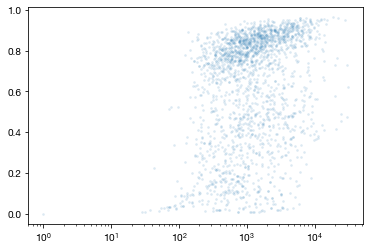

In [34]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.show()

#### Fine-tuned in India 1x

In [47]:
hp_df = pd.read_csv('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/Airbus_original/IoU_hyperparameter_tuning.csv')
hp_df

t_ext  t_bound      mIoU  IoU_50
0     0.1      0.0  0.789476   0.808
1     0.1      0.1  0.833590   0.860
2     0.1      0.2  0.832095   0.828
3     0.2      0.0  0.798997   0.808
4     0.2      0.1  0.842541   0.864
5     0.2      0.2  0.841289   0.832
6     0.3      0.0  0.809592   0.800
7     0.3      0.1  0.847135   0.864
8     0.3      0.2  0.847978   0.832
9     0.4      0.0  0.817930   0.788
10    0.4      0.1  0.852249   0.864
11    0.4      0.2  0.852614   0.832
12    0.5      0.0  0.819182   0.792
13    0.5      0.1  0.847980   0.864
14    0.5      0.2  0.848663   0.836

In [42]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/'
t_ext = 0.4
t_bound = 0.2
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [43]:
print("mIoU:", np.median(IoUs))
print("IoU_50:", np.sum(np.array(IoUs) >= 0.5) / len(IoUs))

mIoU: 0.856257591578409
IoU_50: 0.8702404809619239


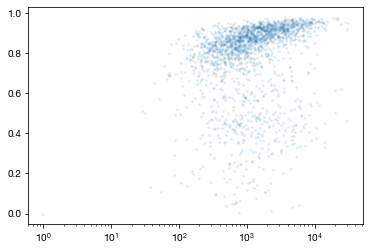

In [44]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.show()

In [48]:
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU2.csv'.format(model_name),
    index=False)

In [49]:
print("mIoU:", np.median(IoUs))
print("IoU_50:", np.sum(np.array(IoUs) >= 0.5) / len(IoUs))

mIoU: 0.8515410992658847
IoU_50: 0.8897795591182365


In [50]:
df_scratch = pd.read_csv('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0003_original-resolution_fromscratch-continued2/Airbus_original/IoU.csv'.format(model_name))

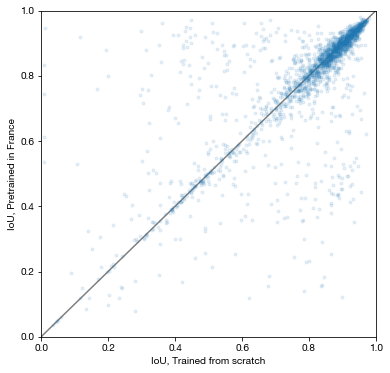

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plt.plot([-1,2], [-1,2], 'k', alpha=0.5)
plt.plot(df_scratch['IoU'], df['IoU'], 'o', alpha=0.1, ms=3)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('IoU, Trained from scratch')
plt.ylabel('IoU, Pretrained in France')
plt.show()

In [64]:
df_scratch['IoU'].values > df['IoU'].values

array([False, False,  True, ..., False, False, False])

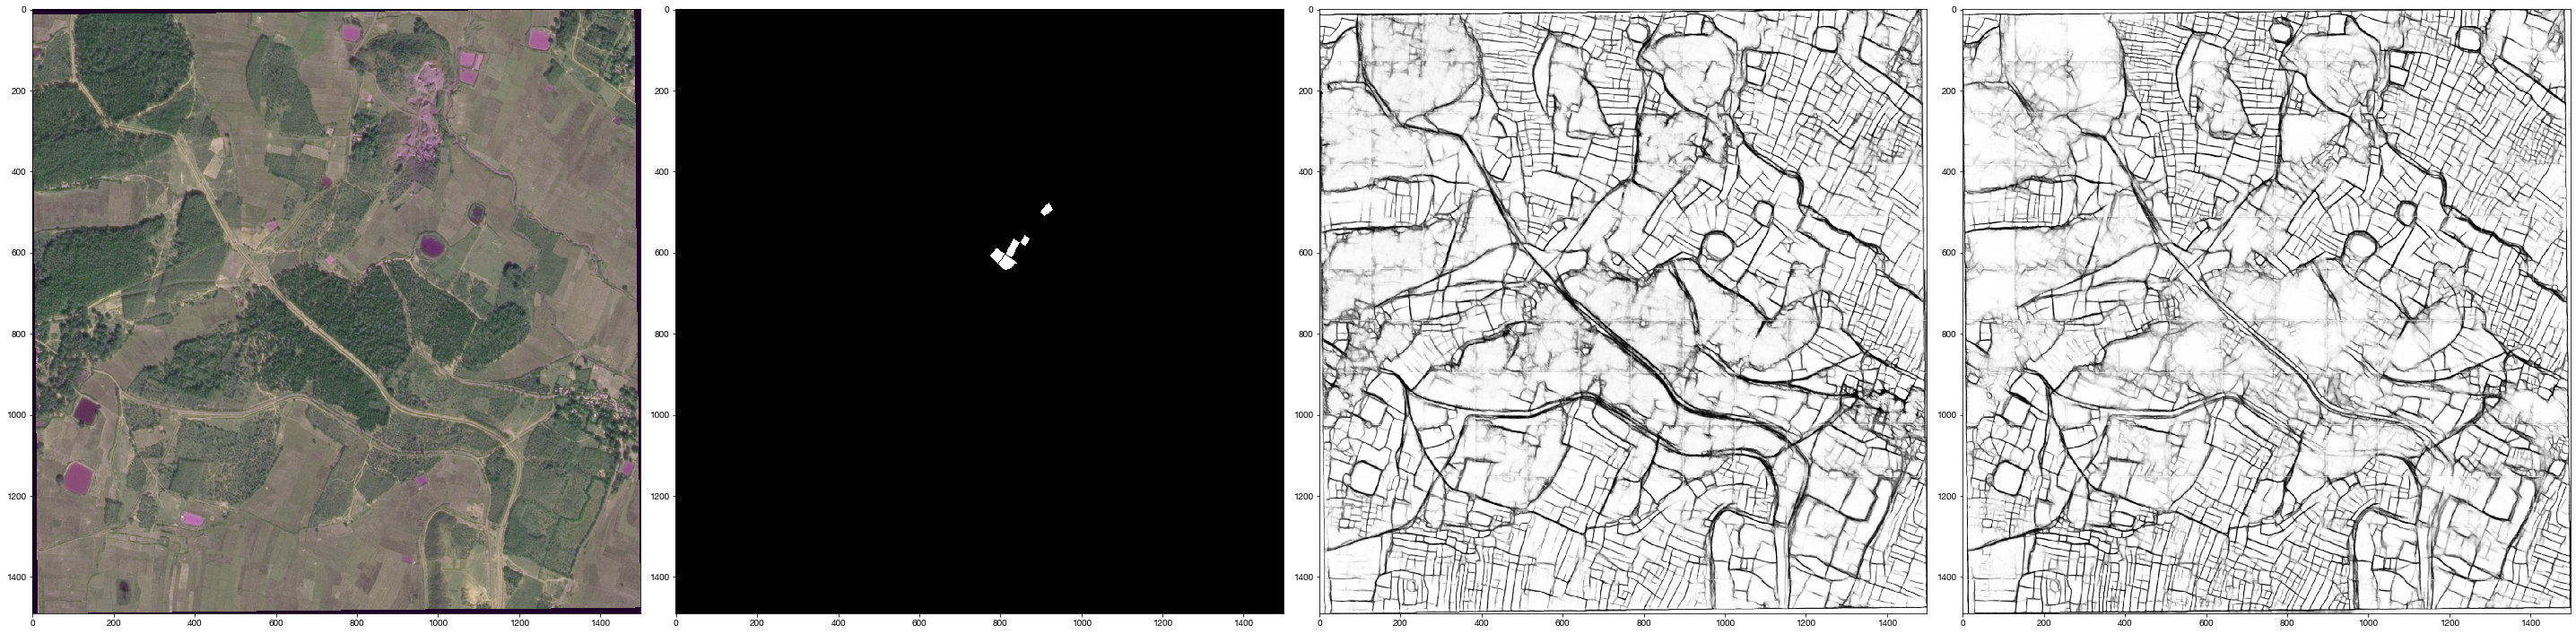

In [91]:
image_id = '1248'
img = imageio.imread('../data/general_blockchain/airbus_false_color/large/original/airbus_geowiki_C{}.png'.format(image_id))
label = imageio.imread('../data/general_blockchain/airbus_labels/large/original/airbus_geowiki_C{}.png'.format(image_id))
extent_full1 = imageio.imread('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/Airbus_original/extent_full/airbus_geowiki_C{}.png'.format(image_id))
extent_full2 = imageio.imread('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0003_original-resolution_fromscratch-continued2/Airbus_original/extent_full/airbus_geowiki_C{}.png'.format(image_id))

fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax[0].imshow(img)
ax[1].imshow(label, cmap='Greys_r')
ax[2].imshow(extent_full1, cmap='Greys_r')
ax[3].imshow(extent_full2, cmap='Greys_r')
plt.tight_layout()
plt.show()

In [88]:
sorted(np.array(field_image_ids)[df_scratch['IoU'].values > df['IoU'].values + 0.2])

['airbus_geowiki_C0002',
 'airbus_geowiki_C0006',
 'airbus_geowiki_C0007',
 'airbus_geowiki_C0010',
 'airbus_geowiki_C0011',
 'airbus_geowiki_C0013',
 'airbus_geowiki_C0017',
 'airbus_geowiki_C0060',
 'airbus_geowiki_C0060',
 'airbus_geowiki_C0101',
 'airbus_geowiki_C0112',
 'airbus_geowiki_C0112',
 'airbus_geowiki_C0134',
 'airbus_geowiki_C0134',
 'airbus_geowiki_C0139',
 'airbus_geowiki_C0143',
 'airbus_geowiki_C0149',
 'airbus_geowiki_C0165',
 'airbus_geowiki_C0165',
 'airbus_geowiki_C0187',
 'airbus_geowiki_C0205',
 'airbus_geowiki_C0237',
 'airbus_geowiki_C0243',
 'airbus_geowiki_C0259',
 'airbus_geowiki_C0276',
 'airbus_geowiki_C0291',
 'airbus_geowiki_C0335',
 'airbus_geowiki_C0344',
 'airbus_geowiki_C0358',
 'airbus_geowiki_C0429',
 'airbus_geowiki_C0429',
 'airbus_geowiki_C0470',
 'airbus_geowiki_C0475',
 'airbus_geowiki_C0506',
 'airbus_geowiki_C0506',
 'airbus_geowiki_C0506',
 'airbus_geowiki_C0516',
 'airbus_geowiki_C0516',
 'airbus_geowiki_C0516',
 'airbus_geowiki_C0518',


In [28]:
# training and val sets
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=val_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU_val.csv'.format(model_name),
    index=False)

0
100
200


In [ ]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=train_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU_train.csv'.format(model_name),
    index=False)

0
100
200
300
400
500
600
700
800
900


In [ ]:
print("done")

#### From scratch India 1x

In [39]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0003_original-resolution_fromscratch-continued2/'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [40]:
print("mIoU:", np.median(IoUs))
print("IoU_50:", np.sum(np.array(IoUs) >= 0.5) / len(IoUs))

mIoU: 0.8539829374613359
IoU_50: 0.8972945891783567


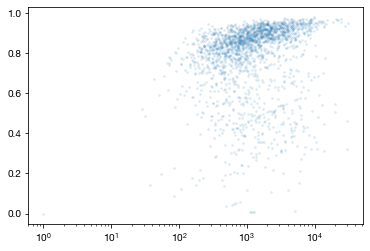

In [41]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.show()

## Dataset size experiments

### Fine-tuned

#### n=5000 fields

In [10]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.0001_original-resolution_n1000_finetuned'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


#### n=2000 fields

In [11]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.0001_original-resolution_n400_finetuned'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


#### n=1000 fields

In [12]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.0001_original-resolution_n200_finetuned'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


#### n=500 fields

In [13]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.0001_original-resolution_n100_finetuned'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


#### n=200 fields

In [27]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.0001_original-resolution_n40_finetuned-continued'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


#### n=100 fields

In [20]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.0001_original-resolution_n20_finetuned-continued'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


### From scratch

#### n=5000 fields

In [21]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.001_original-resolution_n1000_fromscratch'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


#### n=2000 fields

In [22]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.001_original-resolution_n400_fromscratch'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


#### n=1000 fields

In [23]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.001_original-resolution_n200_fromscratch'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


#### n=500 fields

In [24]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.001_original-resolution_n100_fromscratch'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


#### n=200 fields

In [26]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.001_original-resolution_n40_fromscratch-continued'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


#### n=100 fields

In [25]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.001_original-resolution_n20_fromscratch-continued'
t_ext = 0.3
t_bound = 0.1
IoUs, field_sizes, field_image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_original/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


## Airbus 3x downsampled

#### Direct transfer from France, 1x

In [57]:
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/'
t_ext = 0.10
t_bound = 0.05
IoUs, field_sizes = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_3x_downsampled/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [ ]:
print("mIoU:", np.median(IoUs))
print("IoU_50:", np.sum(np.array(IoUs) >= 0.5) / len(IoUs))

In [58]:
np.sum(np.array(IoUs) >= 0.5) / len(IoUs)

0.40981963927855714

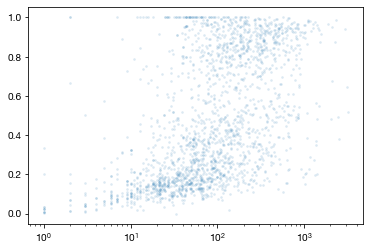

In [59]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.show()

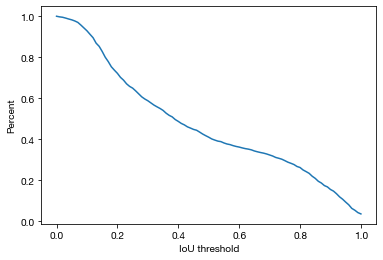

In [60]:
IoU_thresholds = np.linspace(0,1,101)
percent_of_fields = []

for IoU_threshold in IoU_thresholds:
    percent_of_fields.append(
        np.sum(np.array(IoUs) >= IoU_threshold) / len(IoUs))
    
# IoU curve
plt.plot(IoU_thresholds, percent_of_fields)
plt.xlabel('IoU threshold')
plt.ylabel('Percent')
plt.show()

#### Direct transfer from France, 2x+3x downsampled

In [38]:
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/'
t_ext = 0.15
t_bound = 0.05
IoUs, field_sizes = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_3x_downsampled/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [39]:
np.sum(np.array(IoUs) >= 0.5) / len(IoUs)

0.6678356713426854

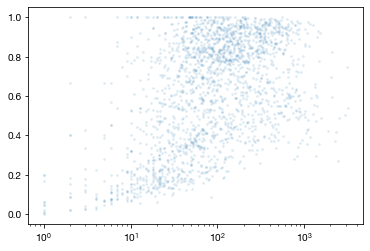

In [40]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.show()

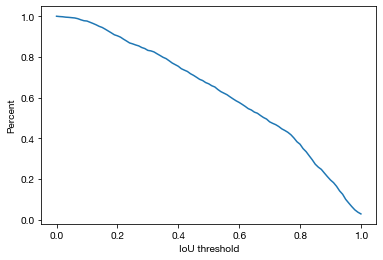

In [41]:
IoU_thresholds = np.linspace(0,1,101)
percent_of_fields = []

for IoU_threshold in IoU_thresholds:
    percent_of_fields.append(
        np.sum(np.array(IoUs) >= IoU_threshold) / len(IoUs))
    
# IoU curve
plt.plot(IoU_thresholds, percent_of_fields)
plt.xlabel('IoU threshold')
plt.ylabel('Percent')
plt.show()

#### Fine-tuned from 2x-3x France

In [47]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_finetuned'
IoUs, field_sizes, image_ids = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name)

0
100
200
300


In [52]:
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes,
    'image_id': image_ids
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_3x_downsampled/IoU.csv'.format(model_name),
    index=False)

In [20]:
np.sum(np.array(IoUs) >= 0.5) / len(IoUs)

0.845691382765531

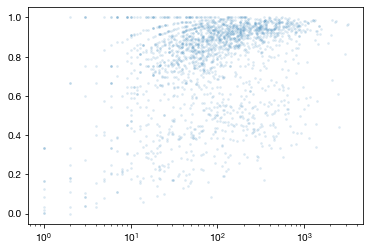

In [15]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.show()

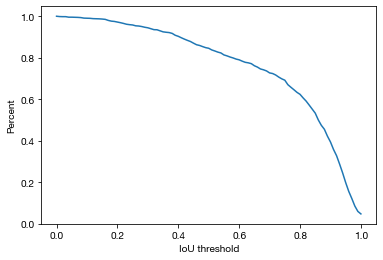

In [17]:
IoU_thresholds = np.linspace(0,1,101)
percent_of_fields = []

for IoU_threshold in IoU_thresholds:
    percent_of_fields.append(
        np.sum(np.array(IoUs) >= IoU_threshold) / len(IoUs))
    
# IoU curve
plt.plot(IoU_thresholds, percent_of_fields)
plt.xlabel('IoU threshold')
plt.ylabel('Percent')
plt.show()

#### Fine-tuned in India, entire dataset

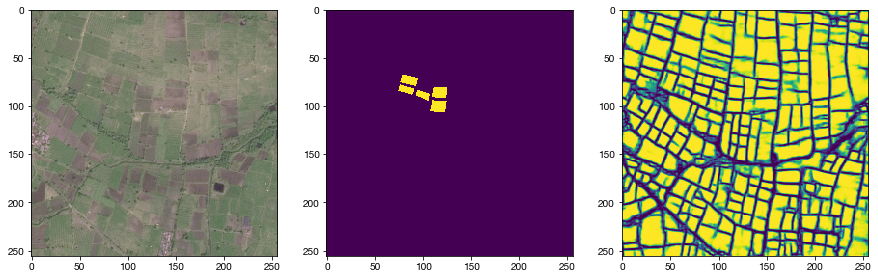

In [63]:
img = imageio.imread('../data/general_blockchain/airbus_false_color/large/3x_downsample_train/airbus_geowiki_C1289.png')
label = imageio.imread('../data/general_blockchain/airbus_labels/large/3x_downsample_erosion2px_train/airbus_geowiki_C1289.png')
pred = np.load('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_finetuned/Airbus_3x_downsampled/extent_predictions/airbus_geowiki_C1289.npy')

fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].imshow(img)
ax[1].imshow(label)
ax[2].imshow(pred)
plt.show()

In [71]:
# training set and validation set
image_ids = ['airbus_geowiki_C' + x for x in train_ids] # val_ids

label_dir = '../data/general_blockchain/airbus_labels/large/3x_downsample_erosion2px_train/' # _val
results_dir = '../results/india/GeneralBlockchain/{}/Airbus_3x_downsampled/'.format(model_name)

IoUs = []
field_sizes = []
field_image_ids = []

for i, image_id in enumerate(image_ids):
    if i % 100 == 0:
        print(i)
    label_path = os.path.join(label_dir, '{}.png'.format(image_id))
    if os.path.exists(label_path):
        example_truth = imageio.imread(label_path)
        extent_pred = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
        boundary_pred = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))
        img_IoUs, img_field_sizes = get_IoUs(example_truth, extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
        IoUs = IoUs + img_IoUs
        field_sizes = field_sizes + img_field_sizes
        field_image_ids = field_image_ids + ([image_id] * len(img_IoUs))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


In [73]:
np.sum(np.array(IoUs) >= 0.5) / len(IoUs)
# train = 0.8618390448131493
# val = 0.8849966953073364

0.8618390448131493

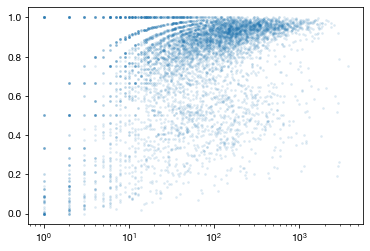

In [74]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.show()

In [75]:
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes,
    'image_id': field_image_ids
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_3x_downsampled/IoU_train.csv'.format(model_name),
    index=False)

#### Trained from scratch in India

In [42]:
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_fromscratch/'
t_ext = 0.25
t_bound = 0.1
IoUs, field_sizes = get_Airbus_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/Airbus_3x_downsampled/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [43]:
np.sum(np.array(IoUs) >= 0.5) / len(IoUs)

0.8191382765531062

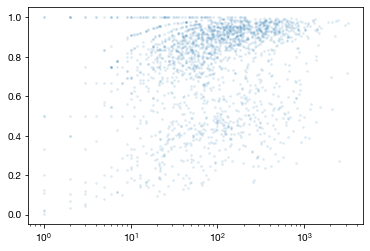

In [49]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.show()

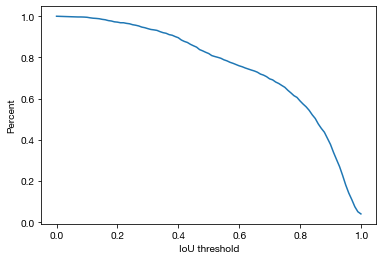

In [50]:
IoU_thresholds = np.linspace(0,1,101)
percent_of_fields = []

for IoU_threshold in IoU_thresholds:
    percent_of_fields.append(
        np.sum(np.array(IoUs) >= IoU_threshold) / len(IoUs))
    
# IoU curve
plt.plot(IoU_thresholds, percent_of_fields)
plt.xlabel('IoU threshold')
plt.ylabel('Percent')
plt.show()